## Setup

In [23]:
import numpy as np
np.random.seed(16)

import sklearn
from sklearn import datasets

## Projected

In [24]:
def ProjGD_Ball(th0, F, gradF, step, max_iter, tol, radius=1):
    def proj_to_ball(x, R):
        temp = np.maximum(R, np.linalg.norm(x, 2))
        return R*x / np.maximum(R, np.linalg.norm(x, 2))
    
    iters =[th0]
    errs = []
    th = th0

    k = 0
    while (True):
        th = th - step*gradF(th)
        n = np.linalg.norm(th, 2)
        th = proj_to_ball(th, radius)
        # print(np.linalg.norm(th,2), f'<={radius}: ', np.linalg.norm(th, 2)<=radius)
        iters.append(th)
        errs.append(np.linalg.norm(iters[-1] - iters[-2]))
        if (k>max_iter or errs[-1]<=tol):
            break
        k = k + 1
        
    return np.array(iters).T, np.array(errs)

A general equation of a paraboloid is stated with three terms:
$$P(x) = x^{T}Ax + Cx + d $$ 
for $A \in \mathbb{R}^{n\times{n}} \succ{0}$, $C\in\mathbb{R}^{n}$, and $d\in\mathbb{R}$

In [25]:
dim = 2
#Generate problem
A = datasets.make_spd_matrix(dim, random_state=16)
A = A

B = np.random.uniform(-1, 1, dim+1)
B = B/np.sum(B)

d = B[-1]
B = np.delete(B, -1)

#goal: recover x given some observed y - values
P = lambda x: x.T.dot(x.T.dot(A)) + B.dot(x) + d
gradP = lambda x: A.dot(x) + B

R = 2

Determine $$ \min_{x} P(x) \text{    s.t.   } ||{x}||\leq{R} $$

where projection $$\Pi_{A}(x) = \frac{R}{max(||x||_2, R)}x$$ 

In [26]:
x0 = np.random.randn(dim)
x0 = R* x0 / np.linalg.norm(x0, 2)
print(x0, np.linalg.norm(x0, 2))

[-0.58608153 -1.91219989] 2.0


$$\nabla{P} = Ax + C$$


In [27]:
iters, errs = ProjGD_Ball(x0, P, gradP, tol=1e-3, step=0.1, max_iter=50, radius=R)

In [28]:
n = 50
t = np.linspace(-3, 3, n)
X, Y = np.meshgrid(t,t)

In [29]:
vals = np.zeros(iters.shape[1])
for i in range(iters.shape[1]):
    vals[i] = P(iters[:,i])

temp = np.zeros(n*n)
Z = np.vstack((X.ravel(), Y.ravel()))
for i in range(Z.shape[1]):
    temp[i] = (P(Z[0:2, i]))
    
temp = temp.reshape((n,n))

In [30]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

In [31]:
# fig = plt.figure(figsize=(8,8))
# ax = plt.axes(projection='3d')
u, v = np.mgrid[0:2 * np.pi:30j, 0:np.pi:20j]
x = 2*(np.cos(u) * np.sin(v))
y = 2*(np.sin(u) * np.sin(v))
z = np.cos(v)*2
# ax.plot_wireframe(x, y, z, alpha=0.3, color='k')
# plt.show()

In [32]:
# # temp = np.vstack((x.ravel(), y.ravel(), z.ravel()))
# fig = plt.figure(figsize=(8,8))
# ax = plt.axes(projection='3d')
# ax.plot(temp[0], temp[1], temp[2])

In [33]:
# %matplotlib qt
fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection='3d')
ax.scatter3D(iters[0,0], iters[1,0], vals[0], s=5, c='r', label='starting point') #starting point
# ax.plot3D(iters[0], iters[1], vals, c='maroon', linewidth=2, label= 'iterations of projected Gradient');
ax.scatter3D(iters[0,1:], iters[1,1:], vals[1:], c='b', s=5, label='iterations of projected Gradient')
ax.plot_surface(X, Y, temp, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False, alpha=0.1) #c=Z[2], cmap='Oranges', alpha=0.3);
ax.plot_wireframe(x, y, z, alpha=0.3, color='k')
ax.set_xlim(-3,3)
ax.set_ylim(-3,3)
ax.set_zlim(-3,3)
# ax.axis('off');
ax.legend();

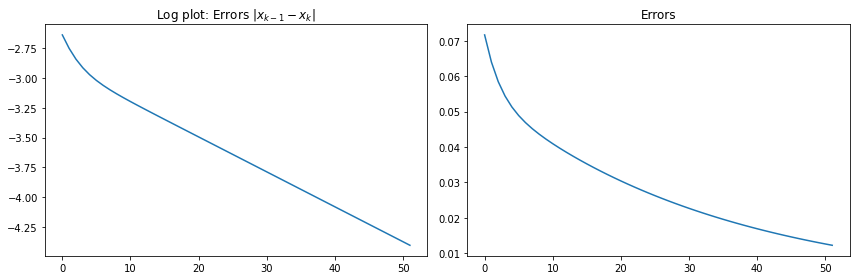

In [12]:
%matplotlib inline
plt.figure(figsize=(12,4), tight_layout=True)
plt.subplot(1,2,1)
plt.plot(np.log(errs))
plt.title(r'Log plot: Errors $|x_{k-1}-x_{k}|$')
plt.subplot(1,2,2)
plt.plot(errs)
plt.title('Errors');


## Franke-Wolfe / Conditional gradient

In [13]:
import numpy as np
np.random.seed(16)

dim = 2
#Generate problem
A = datasets.make_spd_matrix(dim, random_state=16)
A = A 

C = np.random.uniform(-1, 1, dim+1)
#C = C/np.sum(C)

d = C[-1]
C = np.delete(C, -1)

P = lambda x: x.dot(A.dot(x)) + C.dot(x) + d

For conditional gradient on $\ell_2$-ball, solve for 

$s_{k+1} \in \underset{s \in B(0,R)}{\mathrm{argmin}} \big\{ f(x_k) + \langle\ \nabla f(x_k), s - x_k \rangle\ \big\}$ to obtain: 

$$s_{k+1,j} = - R \frac{sign(\nabla f_j(x_k))|\nabla f_j(x_k)|}{||\nabla f(x_k)||_2}$$

In [14]:
def argminS(xk, q):
    # for lq ball
    p = q/(q-1)
    a = np.zeros_like(xk)
    denum = np.sum(np.abs(xk)**p)**(1/q)
    for j in range(len(xk)):
        a[j] = - (np.sign(xk[j])*np.abs(xk[j])**(p-1))/denum        
    return a

q = 2
p = q/(q-1)
xk = np.random.uniform(-1,1, q)
argminS(xk, q)

array([0.95609995, 0.29304077])

In [15]:
def proj_simplex(x, R):
  if x.sum() == R and np.alltrue(x >= 0):
    return x
  u = np.sort(x)[::-1]
  cum = np.cumsum(u)
  rho = np.nonzero(u * np.arange(1, len(x) + 1) > (cum - R))[0][-1]
  theta = float(cum[rho] - R) / rho
  return np.maximum(x - theta, 0)

def proj_ball_l1(x, R = 5):
    u = np.abs(x)
    if u.sum() <= R:
        return x
    return proj_simplex(u, R) * np.sign(x)

In [16]:
def extremePoints_A(d, q):
    # for lq ball
    ext = np.random.randn(d)
    return (ext / np.linalg.norm(ext, q))

def backtracking_ls(sk, f, gradf):
    maxiter = 100
    a = 0.25 #0<a<0.5
    b = 0.5 #0<b<1
    nu = 1
    it = 0
    while True:
        if f(sk - nu*gradf(sk)) >= (f(sk) - a*nu*np.linalg.norm(sk,2)**2):
            # print(f'ls: theta found at iter {it}')
            return nu
        elif it > maxiter:
            print('not found')
            break
        nu = b*nu
        it = it+1
    return 1/0
        

def updatetheta(flag, k, sk, f, gradf):
    if flag=='fixed':
        return 2/(k+2)
    elif flag == 'ls':
        return backtracking_ls(sk, f, gradf)
    else:
        print('Error update rule')
        return
    

def FrankeWolfe(f, gradf, theta_rule, q, dim, maxit=500):
    x0 = extremePoints_A(dim, q)
    k = 0
    x = [x0]
    errs = [1e10]
    while (k<=maxit):
        sk = argminS(gradf(x[-1]), q)

        if np.dot(gradf(x[k]), sk-x[-1]) >= 0:
            print(f'Success at iter {k}')
            break
        thk = theta_rule(k, sk)
        
        x.append( thk*sk + (1-thk)*x[-1])
        errs.append(np.linalg.norm(x[-1] - x[-2], 2))
        k = k+1
    if k>=500:
        print('Not found')
    return np.array(x), np.array(errs)

In [17]:
P = lambda x: x.T.dot(A.dot(x)) + C.dot(x) + d
gradP = lambda x: A.dot(x) + C

In [18]:
theta_rule = lambda k, sk: updatetheta('ls', k, sk, f=P, gradf=gradP)
th, errs = FrankeWolfe(f=P, gradf=gradP, theta_rule=theta_rule, q=2, dim=2, maxit=100)


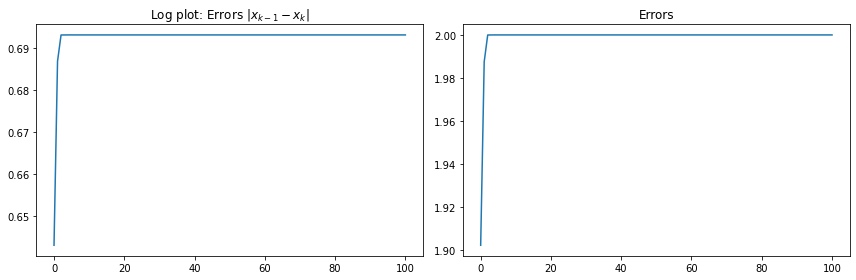

In [19]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(12,4), tight_layout=True)
plt.subplot(1,2,1)
plt.plot(np.log(errs[1:]))
plt.title(r'Log plot: Errors $|x_{k-1}-x_{k}|$')
plt.subplot(1,2,2)
plt.plot(errs[1:])
plt.title('Errors');

In [20]:
print("Final Error: ", errs[-1])

Final Error:  1.9999880192609913


In [21]:
th.shape

(102, 2)

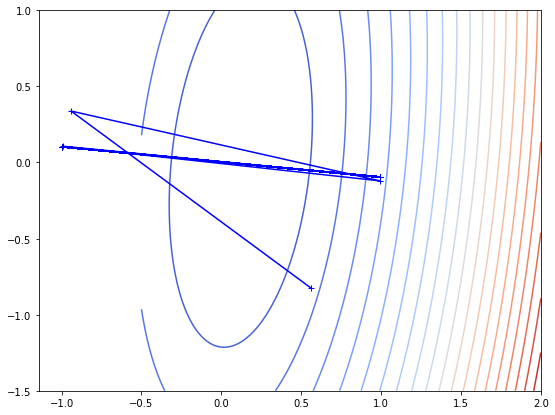

In [22]:
t = np.linspace(-0.5, 2, 200)
X, Y = np.meshgrid(np.linspace(-0.5, 2, 100), np.linspace(-1.5, 1, 100))
Z = np.zeros_like(X)
for i in range(len(X)):
    for j in range(len(Y)):
        Z[i,j] = P(np.array([X[i,j], Y[i,j]]))
# Z = np.reshape(Z, X.shape)
plt.figure(figsize=(9, 7))
plt.contour(X, Y, Z, 20, cmap='coolwarm');
plt.plot(th[:,0], th[:, 1], marker = '+', color = 'b');